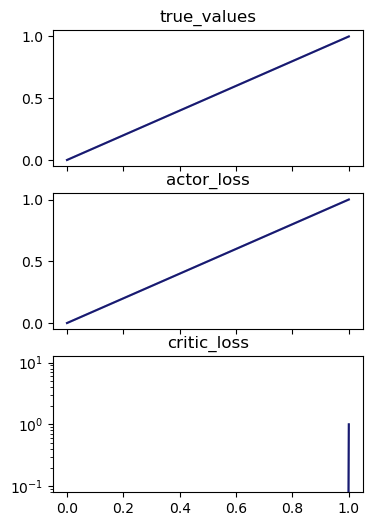

In [1]:
from trainer.trainer import treeTrainer
from agent.agent import normalDistAgent
from env.env import treeEnvB
import env.propagatorB as pB

# propB = pB.CWPropagatorB(device="cuda")
propB = pB.CWDebrisPropagatorB(device="cuda", n_debris=1)

pop = 512
max_gen = 3600
action_bound = 6e-2
env = treeEnvB.from_propagator(propB, population=pop, max_gen=max_gen, device="cuda")
agent = normalDistAgent(obs_dim=propB.obs_dim, action_dim=propB.action_dim,
    actor_hiddens=[512]*10, critic_hiddens=[512]*10, 
    action_lower_bound=-action_bound, action_upper_bound=action_bound, 
    actor_lr=1E-5, critic_lr=5E-4)
T = treeTrainer(env, agent, gamma=0.99)
# T.agent.load("../model/check_point9.ptd")

In [2]:
T.agent.load("../model/seq.ptd")

In [ ]:
import rich.progress
import matplotlib.pyplot as plt
n = 1000
batch_size = 256
horizon = 3600
loss_list = []
with rich.progress.Progress() as pbar:
    task = pbar.add_task("sequential optimize", total=n)
    for _ in range(n):
        states = T.propagator.T.randomInitStates(batch_size).to(agent.device)
        loss = T.propagator.seqOpt(states, agent, horizon)
        loss_list.append(loss.item())
        pbar.update(task, advance=1)
T.agent.save("../model/seq.ptd")
plt.close("all")
plt.plot(loss_list)
plt.show()

In [8]:
from trainer.trainer import treeTrainer
from agent.agent import normalDistAgent
from env.env import treeEnvB
import env.propagatorB as pB
import rich.progress
propB = pB.CWPropagatorB(device="cuda")

action_bound = 6e-2
agent = normalDistAgent(obs_dim=propB.obs_dim, action_dim=propB.action_dim,
                        actor_hiddens=[512]*10, critic_hiddens=[512]*10, 
                        action_lower_bound=-action_bound, action_upper_bound=action_bound, 
                        actor_lr=1E-5, critic_lr=5E-4)

from agent import net
import torch
state_dim = propB.state_dim
action_dim = propB.action_dim
ub = agent.actor.obc.upper_bounds[:action_dim]
lb = agent.actor.obc.lower_bounds[:action_dim]
sw = torch.tensor([1.,1.,1.,0.1,0.1,0.1])
cw = torch.tensor([0.01,0.01,0.01])

tracker = net.trackNet(state_dim, action_dim,
                            n_hiddens=[512]*4, 
                            state_weights=sw, control_weights=cw, 
                            upper_bounds=ub, lower_bounds=lb).to(device=propB.T.device)

def trainTracker(tracker:net.trackNet, prop:pB.dummyPropagatorB, 
                 batch_size=256, horizon=600, episode=100):
    opt = torch.optim.Adam(tracker.parameters(), lr=1e-4)
    loss_list = []
    with rich.progress.Progress() as pbar:
        task = pbar.add_task("sequential optimize", total=episode)
        for _ in range(episode):
            states = prop.T.randomInitStates(batch_size).to(agent.device)
            targets = prop.T.randomInitStates(batch_size).to(agent.device)
            targets[:,3:] = 0 # vel zero
            targets_seq = torch.tile(targets, (horizon,1,1))
            loss = prop.T.seqTrack(states, targets_seq, tracker)
            opt.zero_grad()
            loss.backward()
            opt.step()
            loss_list.append(loss.item())
            pbar.update(task, advance=1)
    return loss_list

Output()

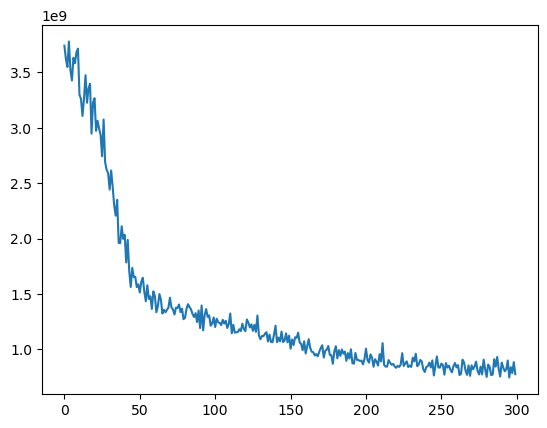

In [11]:
ll = trainTracker(tracker, propB, episode=300)
plt.close("all")
plt.plot(ll)
plt.show()

In [36]:
import data.dicts as D
def testTracker(tracker:net.trackNet, prop:pB.dummyPropagatorB, horizon=1200):
    state = prop.T.randomInitStates(1).to(agent.device)
    obss = prop.T.getObss(state)
    target = prop.T.randomInitStates(1).to(agent.device)
    target[:,3:] = 0 # vel zero
    print(f"target pos: {target.flatten()[:3]}")
    obss_t = prop.T.getObss(target)
    trans_dict = D.init_transDict(horizon, prop.state_dim, prop.obs_dim, prop.action_dim)
    for i in range(horizon):
        trans_dict["states"][i,...] = state.detach().cpu().numpy()
        trans_dict["obss"][i,...] = obss.detach().cpu().numpy()
        tracker_input = torch.hstack((obss,obss_t))
        action = tracker(tracker_input)
        state, _, _, _ = prop.T.propagate(state, action)
        obss = prop.T.getObss(state)
        trans_dict["actions"][i,...] = action.detach().cpu().numpy()
        trans_dict["next_states"][i,...] = state.detach().cpu().numpy()
        trans_dict["next_obss"][i,...] = obss.detach().cpu().numpy()
    return trans_dict

In [42]:
d = testTracker(tracker, propB)

target pos: tensor([ -725.4010, -1155.0952, -1403.4329], device='cuda:0')


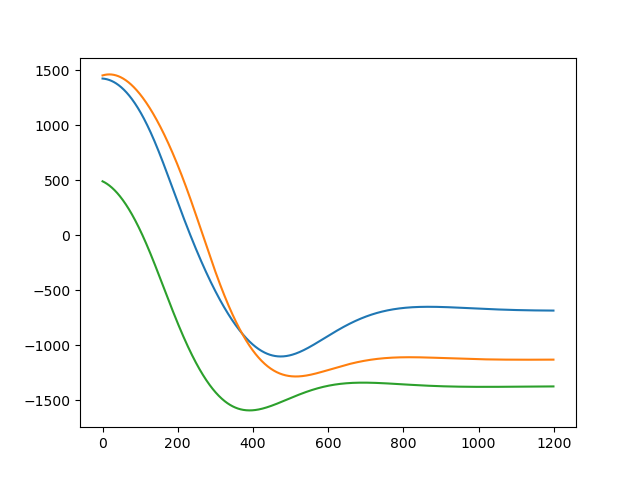

In [43]:
plt.close("all")
for i in range(3):
    plt.plot(d["states"][:,i])

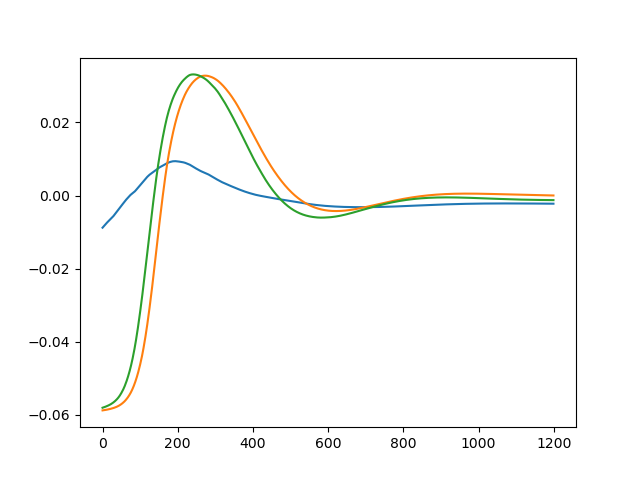

In [39]:
plt.close("all")
for i in range(3):
    plt.plot(d["actions"][:,i])

In [ ]:
T.train(n_epoch=10)

In [ ]:
from plotting.dataplot import dataPlot
_ = dataPlot.from_log("../model/log.npz")

In [ ]:
from plotting.analyze import *
%matplotlib widget
plt.close('all')
_, d = T.test(decide_mode="determined", t_max=.01, g_max=3)
# n_debris = 0
n_debris = T.propagator.N.n_debris
fig, _ = historyFile(d, T.agent, stage=T.testEnv.stage, n_debris=n_debris)

In [ ]:
from plotting.analyze import *
bound = 1
span = [-bound, bound]
criticContour(T.agent, dims=(0,1), span=span, step=201)

In [ ]:
from trainer.example import CWTreeTrainer
from trainer.mpTrainer import mpTreeTrainer

args = {
    "population": 512,
    "batch_size": 2048
}

mpt = mpTreeTrainer(8, trainerType=CWTreeTrainer)
mpt.main_agent.load("../model/check_point9.ptd")
T = mpt.main_trainer

In [ ]:
mpt.train(10, 100, folder="../model/")